In [10]:
import pandas as pd

data_dir = 'C:/ZhangLI/Codes/DataSet/个人违贷/official_data/'
train_pub = pd.read_csv(data_dir+'train_public.csv')
train_net = pd.read_csv(data_dir+'train_internet.csv')
test_pub = pd.read_csv(data_dir+'test_public.csv')

# 必删除
['earlies_credit_mon', 'isDefault', 'policy_code', 'user_id', 'loan_id',]
# # 数据处理
# train_net['isDefault'] = train_net['is_default']
# common_feature = list(set(train_pub.columns).intersection(set(train_net.columns)))
# import copy
# train_pub_new = copy.deepcopy(train_pub)
# train_net_new = copy.deepcopy(train_net)
# c = ['class', 'employer_type', 'industry', 'work_year', 'issue_date', 'earlies_credit_mon']
# common_feature = [i for i in common_feature if i not in c]
# train_pub_new = train_pub_new[common_feature]
# train_net_new = train_net_new[common_feature]
# train_df = pd.concat([train_pub_new, train_net_new])
# train_df.fillna(0, inplace=True)

['earlies_credit_mon', 'isDefault', 'policy_code', 'user_id', 'loan_id']

In [14]:
drop_cols = ['earlies_credit_mon', 'isDefault', 'policy_code', 'user_id', 'loan_id', 'scoring_high', 'scoring_low']

numerical_columns = ['loan_id', 'user_id', 'total_loan', 'year_of_loan', 'interest', 'monthly_payment', 'house_exist', 'censor_status', 'use', 'post_code', 'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low', 'scoring_high', 'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup', 'recircle_b', 'recircle_u', 'initial_list_status', 'app_type', 'title', 'policy_code', 'f0', 'f1', 'f2', 'f3', 'f4', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'isDefault']
category_columns = ['class', 'employer_type', 'industry', 'work_year', 'issue_date', 'earlies_credit_mon']
numerical_columns = [col for col in numerical_columns if col not in drop_cols]

train_net['isDefault'] = train_net['is_default']
common_feature = list(set(train_pub.columns).intersection(set(train_net.columns)))
common_feature = [col for col in common_feature if col not in drop_cols and col in numerical_columns]


<Figure size 432x288 with 0 Axes>

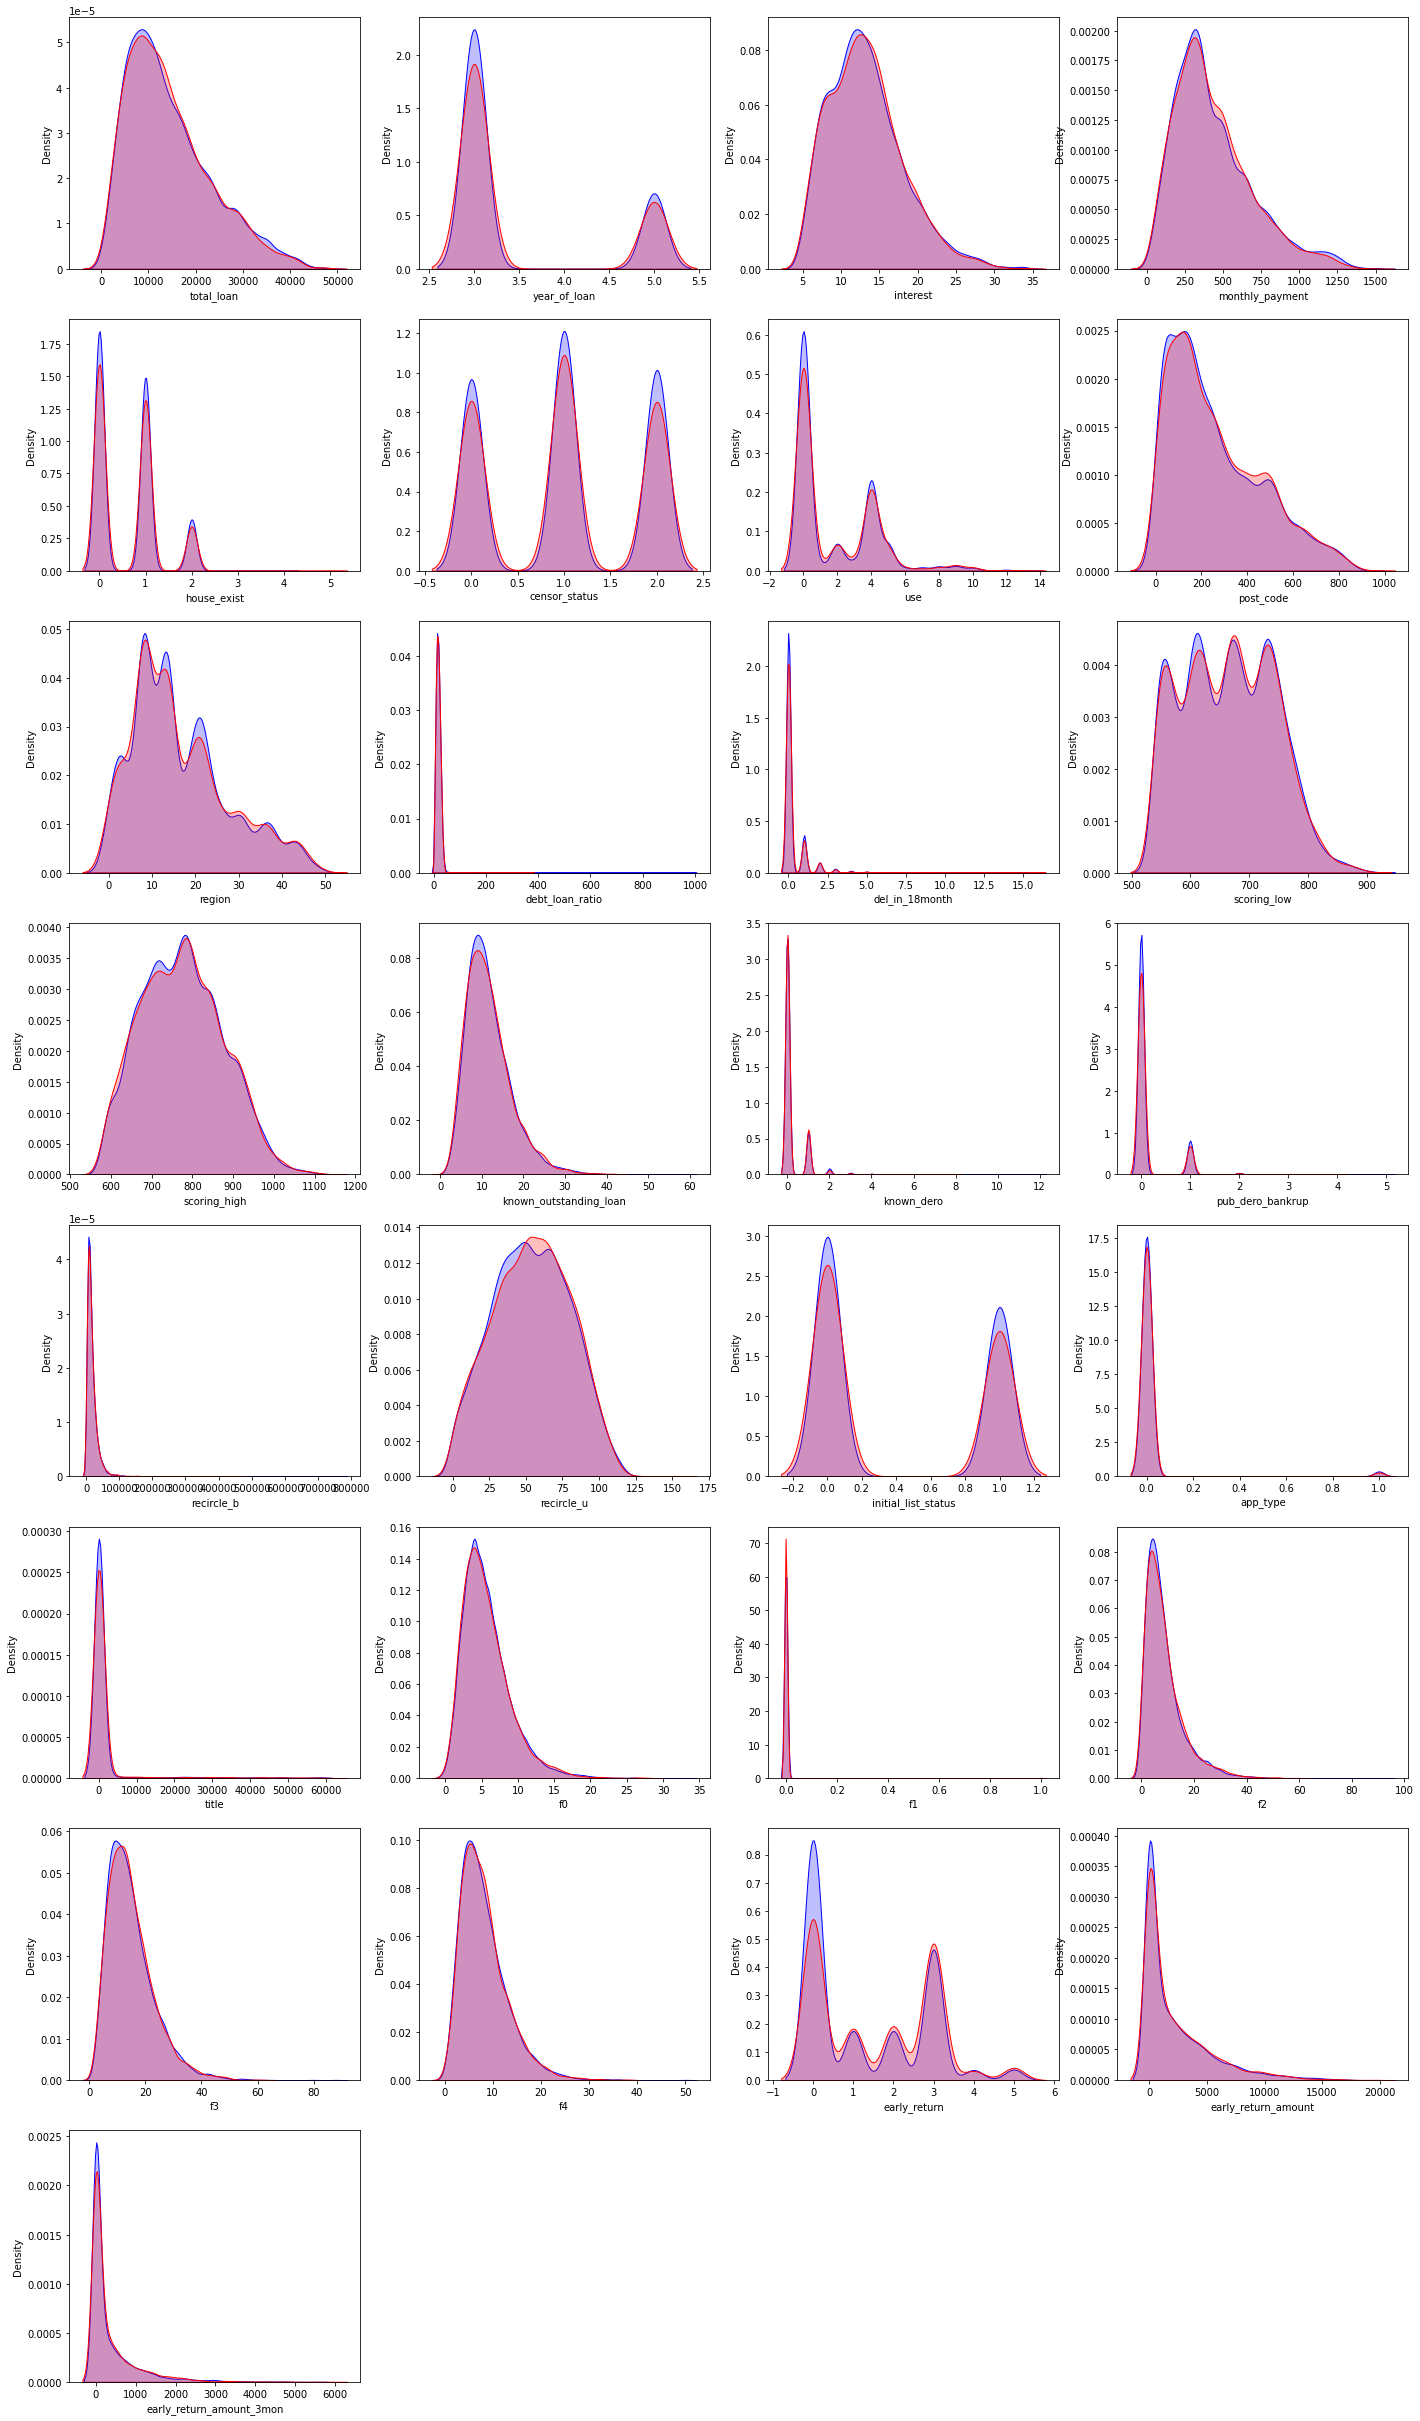

In [11]:
def plot_feature_kde(train_data, test_data, features=[]):
    """连续变量"""
    plt.clf()
    fcols = 4
    frows = len(features)
    plt.figure(figsize=(6*fcols, frows*1.5))
    i = 0
    for col in features:
        i += 1
        plt.subplot(frows//fcols+1, fcols, i)
        sns.kdeplot(train_data[col], color="Blue", shade=True, label='Train')
        sns.kdeplot(test_data[col], color="Red", shade=True, label='Test')
    plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
plot_feature_kde(train_pub, test_pub, features=numerical_columns)


<Figure size 432x288 with 0 Axes>

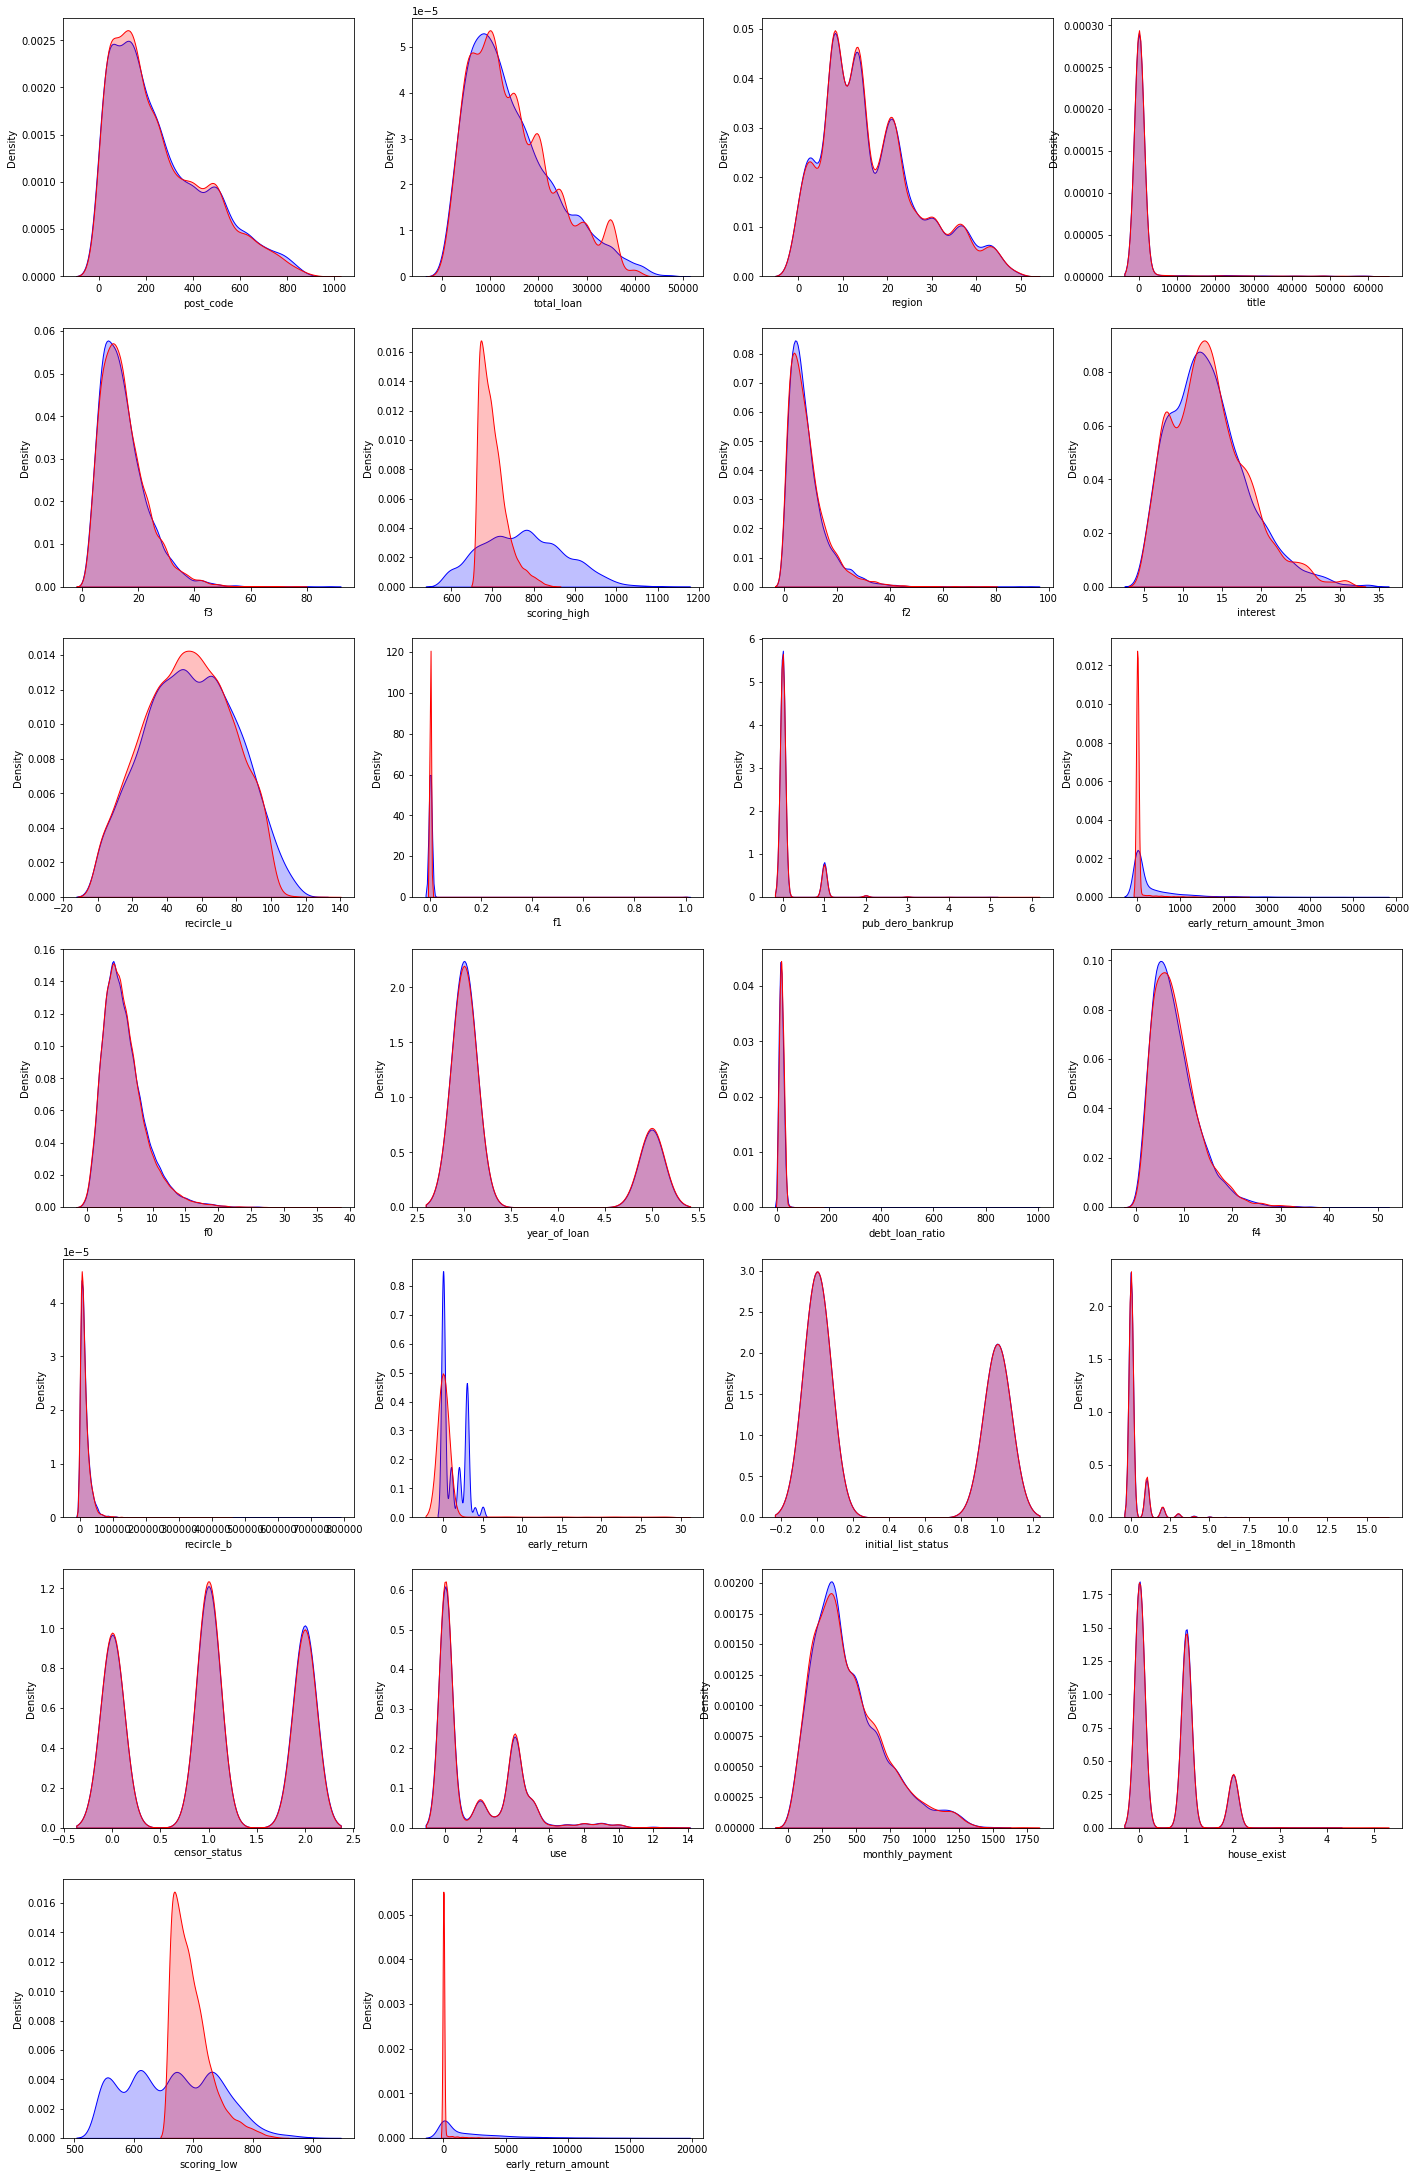

In [41]:
train_net_sample = train_net.sample(n=10000,  random_state=2021)
plot_feature_kde(train_pub, train_net_sample, features=common_feature)

<Figure size 432x288 with 0 Axes>

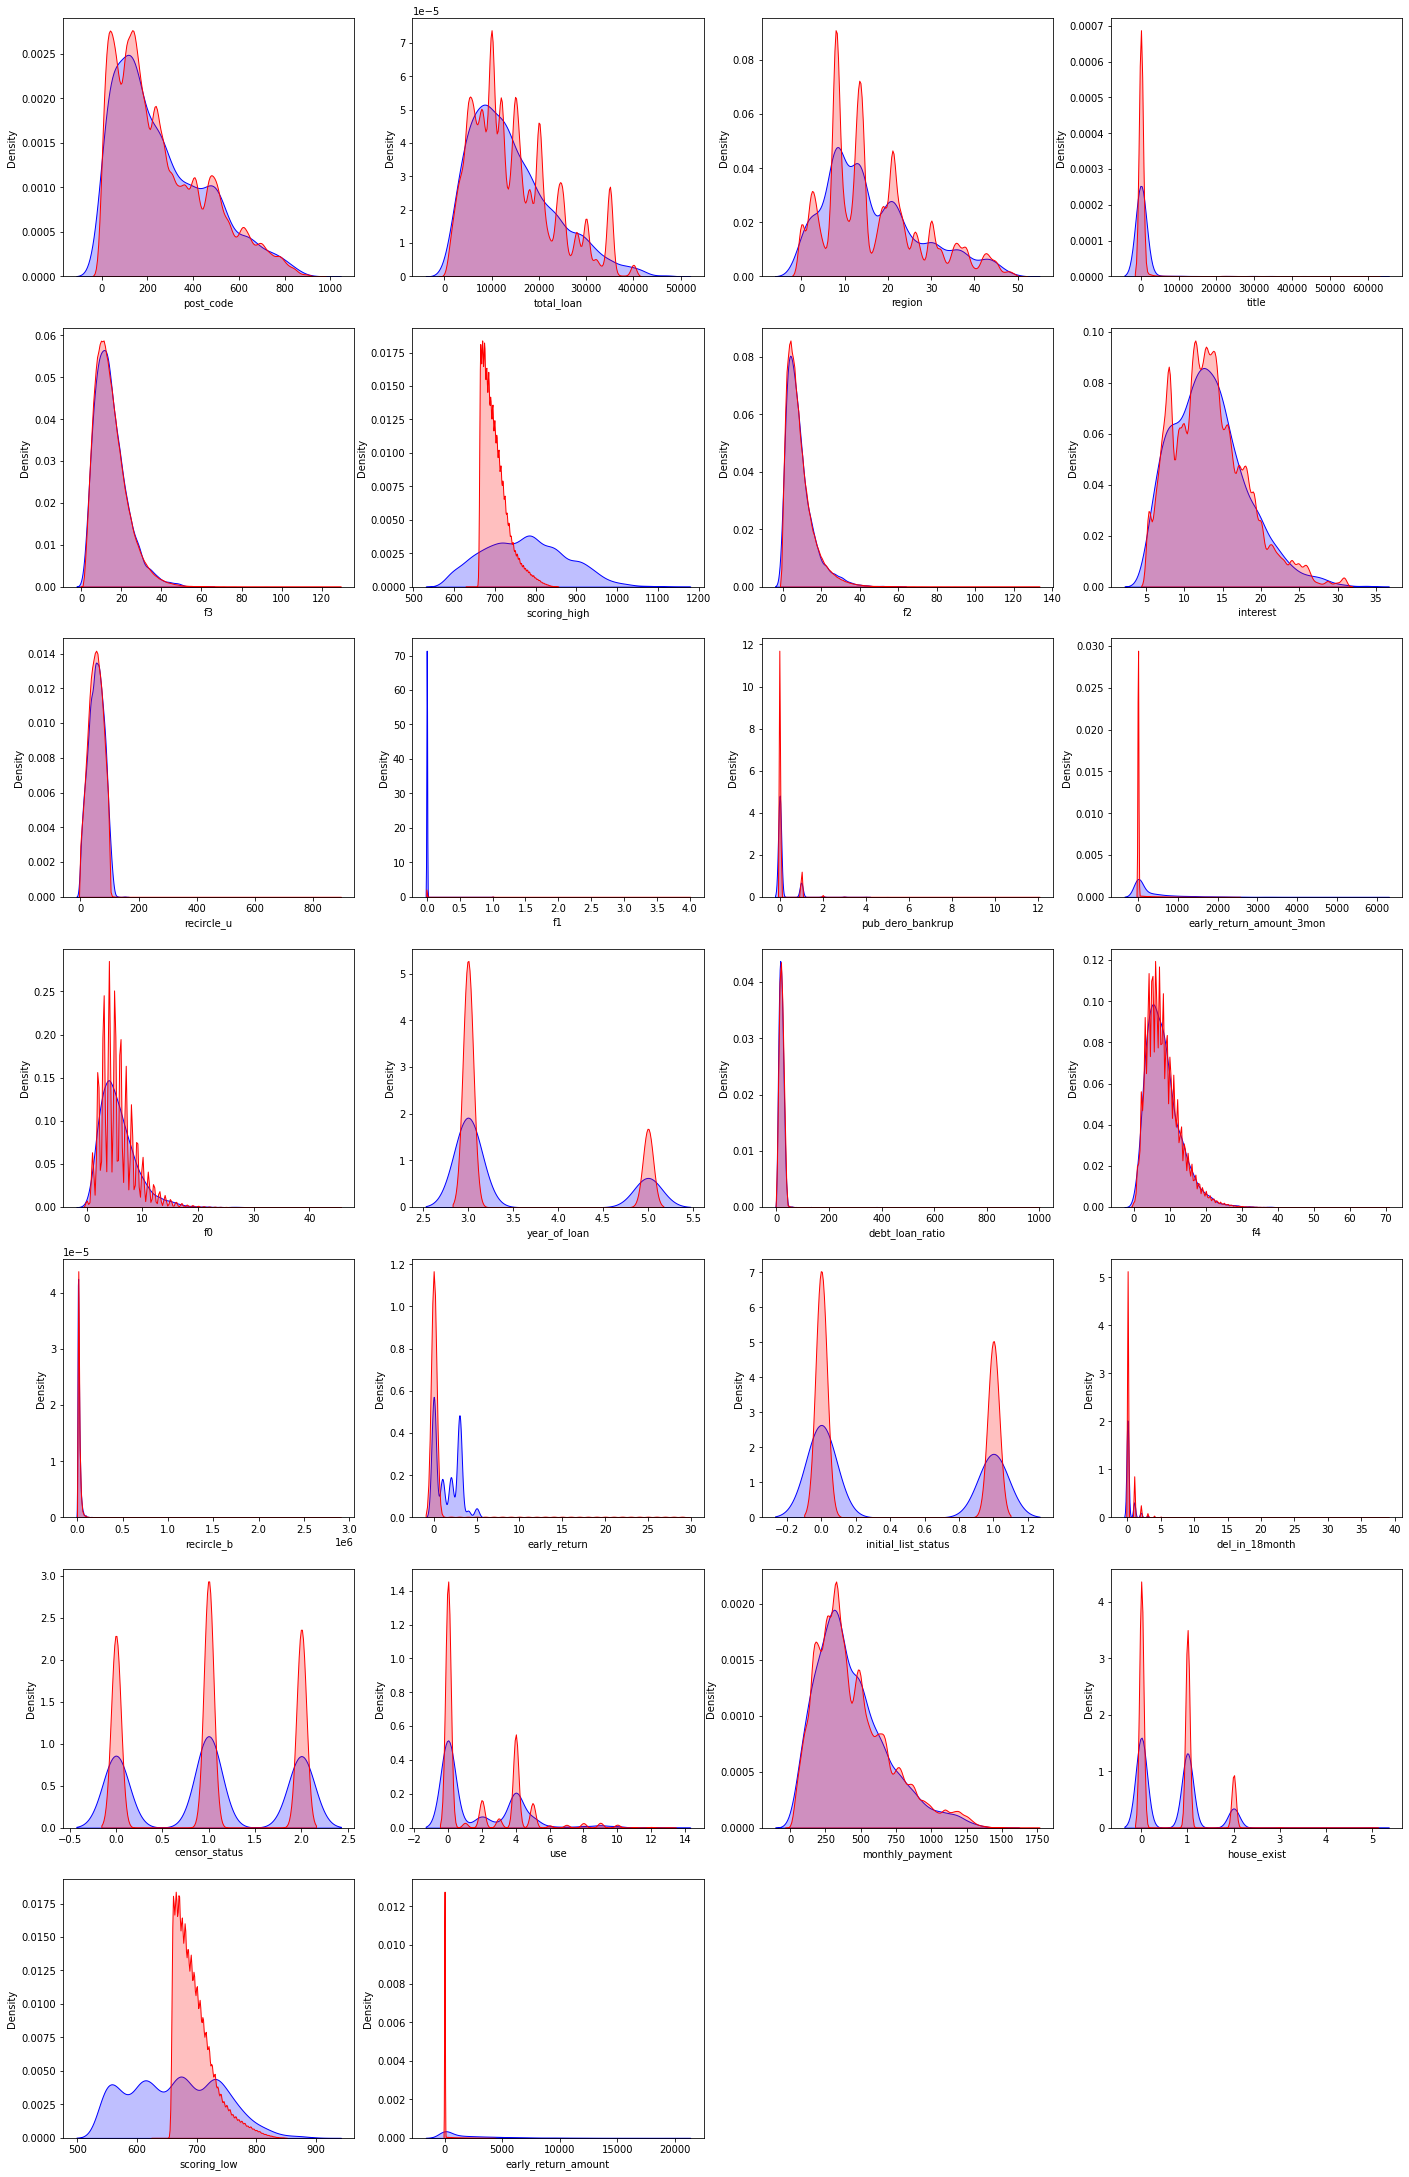

In [16]:
plot_feature_kde(test_pub, train_net, features=common_feature)

<Figure size 432x288 with 0 Axes>

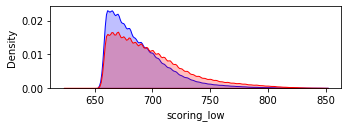

In [54]:
def plot_feature_under_label(dataframe, features=[], label='label'):
    """连续变量"""
    label_1 = dataframe[label] == 1
    label_0 = dataframe[label] == 0
    plt.clf()
    fcols = 4
    frows = len(features)
    plt.figure(figsize=(6*fcols, frows*1.5))
    i = 0
    for col in features:
        i += 1
        plt.subplot(frows//fcols+1, fcols, i)
        sns.kdeplot(dataframe[col][label_1], color="Blue", shade=True, label='不满意')
        sns.kdeplot(dataframe[col][label_0], color="Red", shade=True, label='满意')
        # sns.displot(data=dataframe, x=col, hue=label, kind='kde')
    plt.show()
# plot_feature_under_label(train_pub, ['scoring_low'], 'isDefault')
plot_feature_under_label(train_net, ['scoring_low'], 'isDefault')

In [ ]:
def plot_feature_count(train_data, test_data, features=[]):
    """连续变量"""
    plt.clf()
    fcols = 4
    frows = len(features)
    plt.figure(figsize=(6*fcols, frows*1.5))
    i = 0
    for col in features:
        i += 1
        plt.subplot(frows//fcols+1, fcols, i)
        sns.catplot(kind="count", x=col,  hue="isDefault", data=train_data)
        sns.catplot(kind="count", x=col,  hue="isDefault", data=test_data)
    plt.show()
ca = ['early_return'] # f1 year_of_loan early_return_amount_3mon
plot_feature_count(train_pub, train_net, features=ca)

In [68]:
train_pub[['total_loan', 'monthly_payment', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'interest']]
train_net[['early_return', 'early_return_amount', 'early_return_amount_3mon']]

# 是否提前还款
import copy
dataframe = copy.deepcopy(train_pub)
# 是否提前还款
dataframe['is_early_return'] = (dataframe['early_return'] > 0).astype('int')
# 贷款时长
dataframe['return_duration'] = dataframe['total_loan'] / dataframe['monthly_payment']
# 近3个月是否提前还款
dataframe['is_early_return_amount_3mon'] = (dataframe['early_return_amount_3mon'] > 0).astype('int')
# 总还款金额 占 贷款多少
dataframe['early_return_ration'] = dataframe['early_return_amount'] / dataframe['total_loan']
# 总还款金额占每个月还款金额的多少
dataframe['early_return_monthly_ration'] = dataframe['early_return_amount'] / dataframe['monthly_payment']
# 利率很高 我也贷款 。 年， 年分段
class_cols = ['class', 'use', 'work_type', 'work_year']
mean_cols = ['total', 'monthly_payment', 'interest']
def get_mean_std_of_CAC(dataframe=None, cols1=[], cols2=[], slience=False):
    # get mean/std of feature about another feature
    for col1 in cols1:
        for col2 in cols2:
            if slience:
                print(f'Get the mean/std. Ex: groupby(\'{col1}\')[\'{col2}\'].transform(\' \')')
            dataframe[col1+'_'+ col2+'_mean'] = train_pub.groupby([col1])[col2].transform('mean')
            dataframe[col1+'_'+ col2+'_std'] = train_pub.groupby([col1])[col2].transform('std')
            dataframe[col1+'_'+ col2+'_mean_c'] = dataframe[col2] - dataframe[col1+'_'+ col2+'_mean']
    return dataframe

In [60]:
train_pub[['total_loan', 'monthly_payment', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'interest']]


,total_loan,monthly_payment,early_return,early_return_amount,early_return_amount_3mon,interest
0,31818.18182,1174.91,3,9927,0.0,11.466
1,28000.00000,670.69,0,0,0.0,16.841
2,17272.72727,603.32,0,0,0.0,8.900
3,20000.00000,602.30,0,0,0.0,4.788
4,15272.72727,470.31,0,0,0.0,12.790
...,...,...,...,...,...,...
9995,17727.27273,510.27,2,5287,0.0,15.037
9996,13636.36364,464.95,3,7182,0.0,6.534
9997,24818.18182,708.69,1,8540,2562.0,14.421
9998,20000.00000,727.58,2,6161,616.1,18.450
